In [1]:
import numpy as np
import pandas as pd

input_path = 'IMDB Dataset.csv'
bow_vocab = 10000
vocab_size = 10000 #top text words

data = pd.read_csv(input_path)
review = data['review']
sentiment = data['sentiment']

# Code Label

In [2]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(sentiment)
label = LE.transform(sentiment)
label_num = len(LE.classes_)
print('#label:',label_num)
label_dict = {}
for i in range(label_num):
    label_dict[i] = LE.classes_[i]
label_dict

#label: 2


{0: 'negative', 1: 'positive'}

# Clean text

In [3]:
# Pre-processing of text
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 

wnl = WordNetLemmatizer() 
sw=stopwords.words('english')
del_body_symbol = string.punctuation+ string.digits

def body_remove_html(sentence):
    temp = sentence
    temp = re.sub(r'<[^>]+>', ' ',str(temp))#delete <*>
    temp = re.sub(r'\n', ' ',str(temp))#delete \n
    temp = re.sub(r'\ \d+\ ', ' ',str(temp))#remove int number
    temp = re.sub(r'\ \d+\.\d+\ ', ' ',str(temp))#remove float number
    temp = re.sub(r'\s+[a-zA-Z]\s+', ' ',str(temp))#remove singel letter  
    temp = re.sub(r'[\.,!?]\s', ' ',str(temp))#remove , .for sentence 
    temp = re.sub(r'\s[\(\[]|[\)\}]\s', ' ',str(temp))#remove ()[]for sentence 
    temp = re.sub(r'\:\s', ' ',str(temp))#remove :for sentence 
    temp = re.sub(r'\s+', ' ',str(temp))#merge many ' '
    temp = temp.lower()
    doc = temp.split()
    temp = [wnl.lemmatize(word) for word in doc if word not in sw]
    temp = ' '.join(temp)   
    return temp

def body_remove_sw(sentence):
    #Remove stopwords and convert sentences into a list of words
    words= [w for w in sentence.split(' ') if w not in sw]
    return words

def body_remove_specail_word(words):
    del_element = ''
    while del_element in words:
        words.remove(del_element)  
    return words

def body_wnl(words):
    #Lemmatization
    words=[wnl.lemmatize(word) for word in words]
    return words

def body_preprocessing(sentence,del_estr):
    sentence=body_remove_html(sentence)# preprocessing of  data
    replace = " "*len(del_estr)
    tran_tab = str.maketrans(del_estr, replace)
    sentence = sentence.translate(tran_tab)#Complete the above function of removing punctuation marks
    sentence=body_remove_sw(sentence)#remove stopword
    sentence=body_remove_specail_word(sentence)#delete space
    sentence=body_wnl(sentence)#lemmatization
    return sentence 

clean_review = [body_preprocessing(sentence,del_body_symbol) for sentence in review]
doc_len = [len(inst) for inst in clean_review]
print('max, avg, min', max(doc_len), np.mean(doc_len), min(doc_len))

max, avg, min 1411 118.10528 3


# Code Text

In [4]:
from collections import Counter

def build_vocab(src, vocab_size):
    token_freq_counter = Counter()
    for inst in src:
        token_freq_counter.update(inst)

    word2idx = dict()
    idx2word = dict()

    sorted_word2idx = sorted(token_freq_counter.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [x[0] for x in sorted_word2idx]
    sorted_words = sorted_words[:vocab_size]

    for idx, word in enumerate(sorted_words):
        word2idx[word] = idx

    for idx, word in enumerate(sorted_words):
        idx2word[idx] = word
    
    print("Total vocab_size: %d, predefined vocab_size: %d" % (len(sorted_word2idx), vocab_size))
    return word2idx, idx2word, token_freq_counter

print('Building vocabulary')
word2idx, idx2word, token_freq_counter = build_vocab(clean_review, vocab_size)

Building vocabulary
Total vocab_size: 91365, predefined vocab_size: 10000


# LDA

## bow_dictionary

In [5]:
import gensim

topic_num = 24
topic_min_p = .2

bow_dictionary = gensim.corpora.Dictionary(clean_review)
# Remove single letter or character tokens
len_1_words = list(filter(lambda w: len(w) == 1, bow_dictionary.values()))
bow_dictionary.filter_tokens(list(map(bow_dictionary.token2id.get, len_1_words)))
print("The original bow vocabulary: %d" % len(bow_dictionary))
bow_dictionary.filter_extremes(no_below=3, keep_n=bow_vocab)
bow_dictionary.compactify()
bow_dictionary.id2token = dict([(id, t) for t, id in bow_dictionary.token2id.items()])
# for debug
sorted_dfs = sorted(bow_dictionary.dfs.items(), key=lambda x: x[1], reverse=True)
sorted_dfs_token = [(bow_dictionary.id2token[id], cnt) for id, cnt in sorted_dfs]
print('The top 50 non-stop-words: ', sorted_dfs_token[:50])
print("Bow dict_size: %d after filtered" % len(bow_dictionary))

C:\Users\Pengyu\miniconda3\envs\tf17\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


The original bow vocabulary: 91305
The top 50 non-stop-words:  [('like', 23534), ('time', 20309), ('good', 19067), ('make', 16882), ('see', 16774), ('even', 16717), ('character', 16503), ('get', 16396), ('would', 16180), ('story', 15634), ('well', 15055), ('really', 15048), ('much', 14080), ('scene', 13221), ('also', 12752), ('way', 12734), ('great', 12627), ('first', 12613), ('made', 12421), ('people', 12393), ('thing', 12107), ('bad', 11788), ('could', 11736), ('think', 11329), ('go', 11182), ('watch', 11069), ('know', 10746), ('acting', 10696), ('seen', 10690), ('life', 10479), ('plot', 10330), ('actor', 10185), ('many', 10143), ('say', 10080), ('end', 10079), ('never', 10006), ('year', 9883), ('two', 9784), ('ever', 9681), ('best', 9674), ('look', 9597), ('little', 9441), ('love', 9348), ('show', 9286), ('better', 9256), ('come', 8933), ('take', 8928), ('still', 8661), ('work', 8477), ('give', 8181)]
Bow dict_size: 10000 after filtered


## LDA model

In [6]:
src_bow = [bow_dictionary.doc2bow(src) for src in clean_review]
lda = gensim.models.ldamodel.LdaModel(corpus=src_bow,
                                      id2word=bow_dictionary, 
                                      num_topics=topic_num, 
                                      random_state=0)

In [12]:
word_num = 5
for i in range(24):
    print('%d topic:\n'%i, lda.show_topic(topicid = i, topn= word_num))

0 topic:
 [('horror', 0.03165703), ('zombie', 0.009751752), ('gore', 0.009486758), ('house', 0.009358741), ('killer', 0.009268626)]
1 topic:
 [('love', 0.015852194), ('family', 0.012496789), ('girl', 0.010926266), ('woman', 0.010739934), ('life', 0.010474755)]
2 topic:
 [('song', 0.030931272), ('music', 0.022292593), ('musical', 0.018956356), ('dance', 0.012649458), ('number', 0.010822128)]
3 topic:
 [('series', 0.029452324), ('show', 0.029437896), ('episode', 0.02382722), ('tv', 0.011243004), ('first', 0.008796742)]
4 topic:
 [('great', 0.020495124), ('performance', 0.017500045), ('role', 0.015266943), ('best', 0.012644244), ('actor', 0.012617618)]
5 topic:
 [('comedy', 0.017737588), ('french', 0.013867137), ('jackson', 0.007711746), ('work', 0.007597373), ('de', 0.007017829)]
6 topic:
 [('game', 0.019076), ('action', 0.0109582), ('like', 0.009530963), ('effect', 0.008632053), ('art', 0.0070917704)]
7 topic:
 [('man', 0.011973486), ('get', 0.010032506), ('police', 0.006868429), ('murd

## 3-2

In [12]:
src_topic = [lda.get_document_topics(topici) for topici in src_bow]

In [13]:
src_single_topic = [i[0][0] for i in src_topic]

In [14]:
assert len(src_single_topic)==len(label) and len(clean_review)==len(label)

### topic 0

In [15]:
def sentence2id(sentence, word2idx):
    src_id = [word2idx[w] for w in sentence if w in word2idx]
    return src_id

choose_topic = 0
text = []
target = []
for i, value in enumerate(src_single_topic):
    if value==choose_topic:
        sentence = clean_review[i]
        src_id = sentence2id(sentence, word2idx)
        text.append(src_id)
        target.append(label[i])
print('topic %d have %d instances'%(choose_topic, len(target)))

topic 0 have 12923 instances


In [16]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_WORDS = 200

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

Using TensorFlow backend.
/data/pengyu/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/pengyu/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/pengyu/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/pengyu/anaconda3/

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))#see the legth of testing samples

test number: 1293


In [18]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
tensorflow_version = tf.__version__
gpu_available = tf.test.is_gpu_available()
print("tensorflow_version", tensorflow_version, "GPU available", gpu_available)

tensorflow_version 1.14.0 GPU available True


#### GRU




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,031,810
Trainable params: 

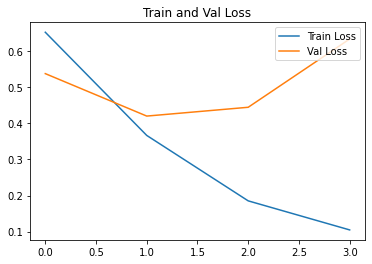

In [20]:
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Embedding, Dropout, GRU, MaxPooling1D, Lambda, Concatenate, \
    Multiply, RepeatVector, Flatten, Activation, Permute, Conv1D
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

index_from = 0#From which number are meaningful words
batch_size = 256#256
embedding_size = 100#100
rnn_units = 64
drop_rate = 0.1
num_epoch = 50
model_name_path = 'BiGRU_best_model.h5'
body_num = vocab_size

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    bigru=GRU(units=rnn_units, return_sequences=False)(embeddings)#bi-lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#iterative 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()


In [116]:
from sklearn import metrics
import seaborn as sns

def myResult():
    print("Training set:")
    print("Accuracy and other indicators：")
    print(metrics.classification_report(y_train,predict_target, digits=4))
    
    print("confusion matrix：")
    cm = metrics.confusion_matrix(y_train,predict_target)
    print(cm)
    plt.figure(figsize=(4,3))
    sns.heatmap(pd.DataFrame(cm),annot=True,cmap="YlGnBu")
    plt.show()
    
    #The prediction effect on the training set,
    print("The prediction effect on the training set:")
    plt.plot(y_train[20:50]) 
    plt.plot(predict_target[20:50],'o')
    plt.legend(('y_train','y_predict'))
    plt.title('train')
    plt.show()

    print("Test set:")
    print("Accuracy and other indicators：")
    print(metrics.classification_report(y_test,predict_target2, digits=4))
    
    print("confusion matrix：")
    cm = metrics.confusion_matrix(y_test,predict_target2)
    print(cm)
    plt.figure(figsize=(4,3))
    sns.heatmap(pd.DataFrame(cm),annot=True,cmap="YlGnBu")
    plt.show()    
    
    #prediction on test set
    print("prediction on test set:")
    plt.plot(y_test[20:50]) 
    plt.plot(predict_target2[20:50],'o')
    plt.legend(('y_test','y_predict'))
    plt.title('test')
    plt.show()

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6961
           1       0.96      0.97      0.96      4669

    accuracy                           0.97     11630
   macro avg       0.97      0.97      0.97     11630
weighted avg       0.97      0.97      0.97     11630

混淆矩阵：
[[6770  191]
 [ 140 4529]]


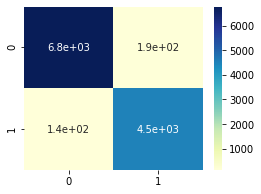

在训练集上的预测效果:


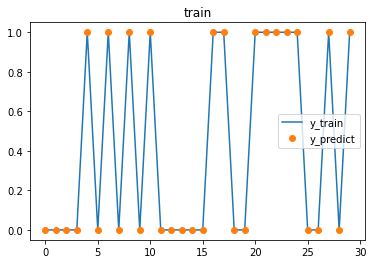

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       760
           1       0.83      0.79      0.81       533

    accuracy                           0.85      1293
   macro avg       0.85      0.84      0.84      1293
weighted avg       0.85      0.85      0.85      1293

混淆矩阵：
[[677  83]
 [114 419]]


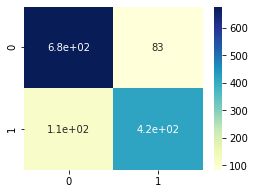

在测试集上的预测效果:


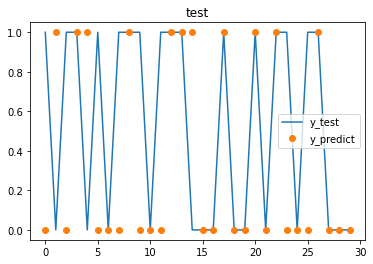

In [21]:
#myModel.load_weights(model_name_path) # Load the best training results
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)#result
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)#resukt
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()#Output evaluation index

### topic 1~4

topic 1 have 11663 instances
test number: 1167
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 1,031,810
Trainable params: 1,031,810
Non-trainable params: 0
_________________________________________________________________
None
Train on 9446 samples, validate on 1050 samples
Epoch 1/50
9446

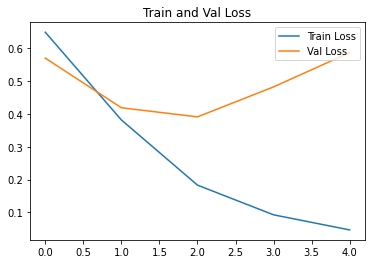

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4203
           1       0.99      0.99      0.99      6293

    accuracy                           0.98     10496
   macro avg       0.98      0.98      0.98     10496
weighted avg       0.98      0.98      0.98     10496

混淆矩阵：
[[4112   91]
 [  89 6204]]


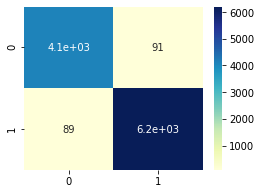

在训练集上的预测效果:


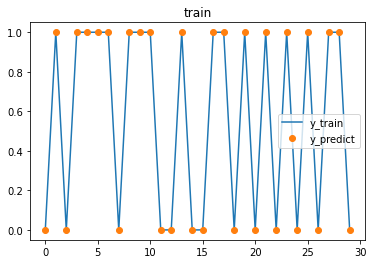

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       484
           1       0.85      0.87      0.86       683

    accuracy                           0.83      1167
   macro avg       0.83      0.83      0.83      1167
weighted avg       0.83      0.83      0.83      1167

混淆矩阵：
[[378 106]
 [ 88 595]]


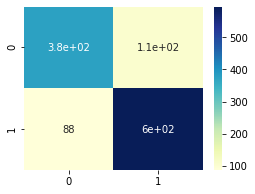

在测试集上的预测效果:


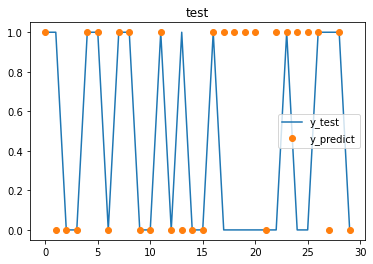

In [22]:
choose_topic = 1
text = []
target = []
for i, value in enumerate(src_single_topic):
    if value==choose_topic:
        sentence = clean_review[i]
        src_id = sentence2id(sentence, word2idx)
        text.append(src_id)
        target.append(label[i])
print('topic %d have %d instances'%(choose_topic, len(target)))

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))#length of test set

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#iterative image
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) # load the best training result
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)#predicted result
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)#predict result
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()#Output evaluation index

topic 2 have 5312 instances
test number: 532
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 1,031,810
Trainable params: 1,031,810
Non-trainable params: 0
_________________________________________________________________
None
Train on 4302 samples, validate on 478 samples
Epoch 1/50
4302/43

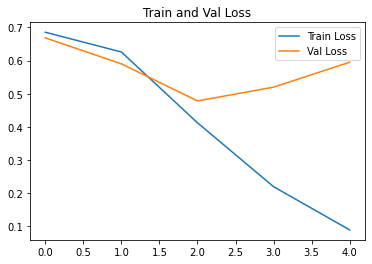

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2145
           1       0.98      0.97      0.98      2635

    accuracy                           0.97      4780
   macro avg       0.97      0.97      0.97      4780
weighted avg       0.97      0.97      0.97      4780

混淆矩阵：
[[2090   55]
 [  73 2562]]


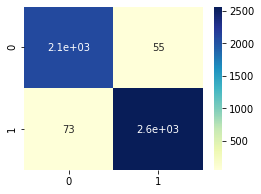

在训练集上的预测效果:


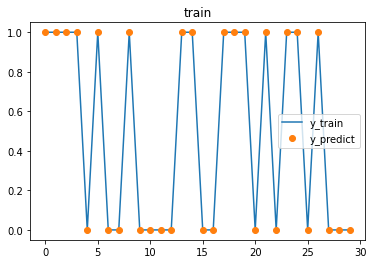

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       253
           1       0.84      0.87      0.85       279

    accuracy                           0.84       532
   macro avg       0.84      0.84      0.84       532
weighted avg       0.84      0.84      0.84       532

混淆矩阵：
[[206  47]
 [ 37 242]]


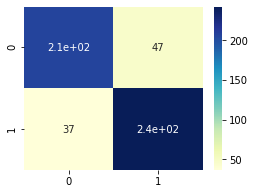

在测试集上的预测效果:


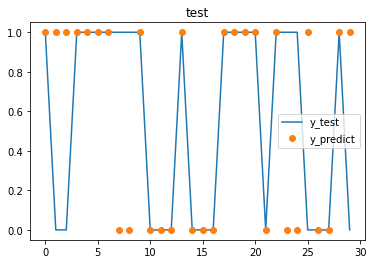

In [23]:
choose_topic = 2
text = []
target = []
for i, value in enumerate(src_single_topic):
    if value==choose_topic:
        sentence = clean_review[i]
        src_id = sentence2id(sentence, word2idx)
        text.append(src_id)
        target.append(label[i])
print('topic %d have %d instances'%(choose_topic, len(target)))

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))#length

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#iterative image
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) # load best result 
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)#result
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)#result
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()#Output evaluation index

topic 3 have 5498 instances
test number: 550
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 1,031,810
Trainable params: 1,031,810
Non-trainable params: 0
_________________________________________________________________
None
Train on 4453 samples, validate on 495 samples
Epoch 1/50
4453/44

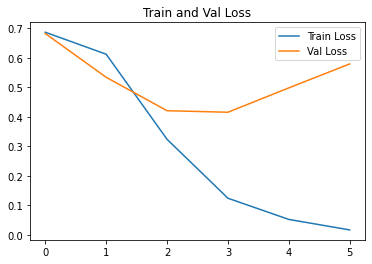

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2306
           1       0.98      0.99      0.98      2642

    accuracy                           0.98      4948
   macro avg       0.98      0.98      0.98      4948
weighted avg       0.98      0.98      0.98      4948

混淆矩阵：
[[2259   47]
 [  37 2605]]


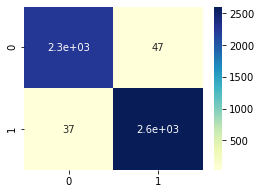

在训练集上的预测效果:


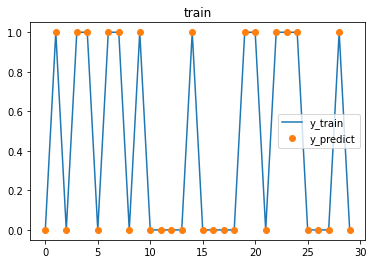

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       264
           1       0.84      0.86      0.85       286

    accuracy                           0.84       550
   macro avg       0.84      0.84      0.84       550
weighted avg       0.84      0.84      0.84       550

混淆矩阵：
[[217  47]
 [ 39 247]]


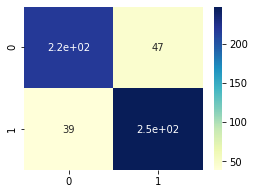

在测试集上的预测效果:


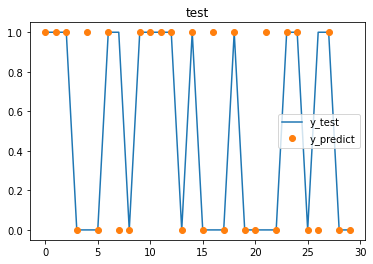

In [24]:
choose_topic = 3
text = []
target = []
for i, value in enumerate(src_single_topic):
    if value==choose_topic:
        sentence = clean_review[i]
        src_id = sentence2id(sentence, word2idx)
        text.append(src_id)
        target.append(label[i])
print('topic %d have %d instances'%(choose_topic, len(target)))

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))#length

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#iterative image
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) # load best result 
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)#predict result
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)#predict result
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()#Output evaluation index

topic 4 have 5771 instances
test number: 578
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 1,031,810
Trainable params: 1,031,810
Non-trainable params: 0
_________________________________________________________________
None
Train on 4673 samples, validate on 520 samples
Epoch 1/50
4673/46

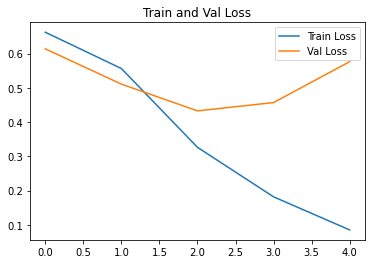

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1815
           1       0.98      0.98      0.98      3378

    accuracy                           0.97      5193
   macro avg       0.97      0.97      0.97      5193
weighted avg       0.97      0.97      0.97      5193

混淆矩阵：
[[1740   75]
 [  59 3319]]


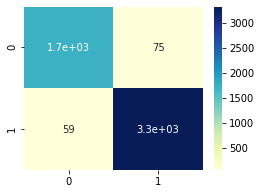

在训练集上的预测效果:


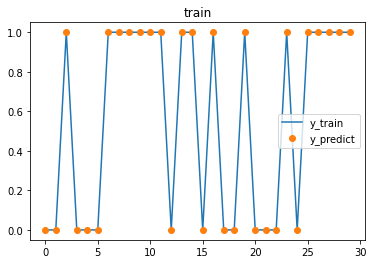

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0       0.75      0.65      0.69       217
           1       0.80      0.87      0.84       361

    accuracy                           0.79       578
   macro avg       0.78      0.76      0.77       578
weighted avg       0.78      0.79      0.78       578

混淆矩阵：
[[140  77]
 [ 46 315]]


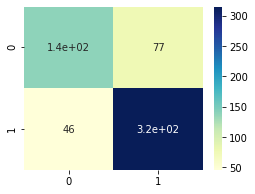

在测试集上的预测效果:


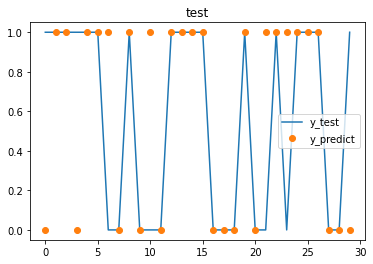

In [25]:
choose_topic = 4
text = []
target = []
for i, value in enumerate(src_single_topic):
    if value==choose_topic:
        sentence = clean_review[i]
        src_id = sentence2id(sentence, word2idx)
        text.append(src_id)
        target.append(label[i])
print('topic %d have %d instances'%(choose_topic, len(target)))

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) 
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

## 

In [190]:
text = []
target = []
for i, value in enumerate(src_single_topic):
    sentence = clean_review[i]
    src_id = sentence2id(sentence, word2idx)
    text.append(src_id)
    target.append(label[i])
print('have %d instances'%(len(target)))

text_id = pad_sequences(text, padding='post', truncating='post', maxlen=MAX_WORDS)
target=to_categorical(target)

x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))


have 50000 instances
test number: 5000


#### LSTM

Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_138 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_85 (Embedding)     (None, 200, 2)            20000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dropout_109 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 2)                 6         
Total params: 20,046
Trainable params: 20,046
Non-trainable params: 0
_________________________________________________________________
None
Train on 40500 samples, validate on 4500 samples
Epoch 1/50
40500/40500 [==============================] - 88s 2ms/

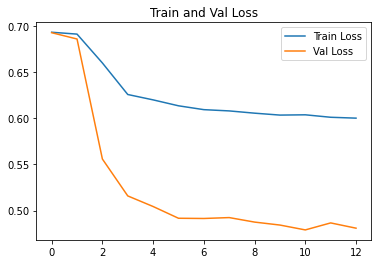

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9491    0.9007    0.9242     22447
           1     0.9059    0.9519    0.9283     22553

    accuracy                         0.9263     45000
   macro avg     0.9275    0.9263    0.9263     45000
weighted avg     0.9274    0.9263    0.9263     45000

混淆矩阵：
[[20217  2230]
 [ 1085 21468]]


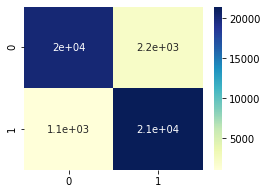

在训练集上的预测效果:


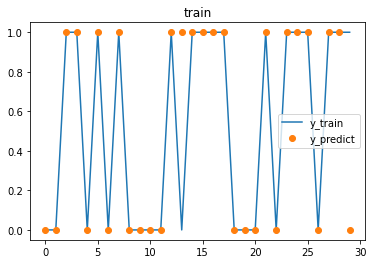

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9075    0.8304    0.8673      2553
           1     0.8375    0.9117    0.8730      2447

    accuracy                         0.8702      5000
   macro avg     0.8725    0.8711    0.8701      5000
weighted avg     0.8732    0.8702    0.8701      5000

混淆矩阵：
[[2120  433]
 [ 216 2231]]


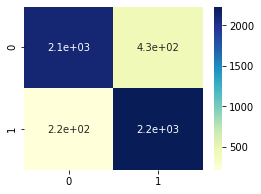

在测试集上的预测效果:


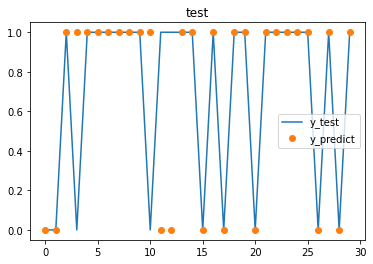

In [191]:
from keras.layers import LSTM

embedding_size = 2
rnn_units = 2
drop_rate = 0.9

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    bigru=LSTM(units=rnn_units, return_sequences=False)(embeddings)#bi-lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#iterative image
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) # load best result
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)#predict ressult
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)#predict result
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()#Output evaluation index

#### GRU

test number: 5000
Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_86 (Embedding)     (None, 200, 2)            20000     
_________________________________________________________________
gru_99 (GRU)                 (None, 2)                 30        
_________________________________________________________________
dropout_110 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 6         
Total params: 20,036
Trainable params: 20,036
Non-trainable params: 0
_________________________________________________________________
None
Train on 40500 samples, validate on 4500 samples
Epoch 1/50
40500/40500 [========================

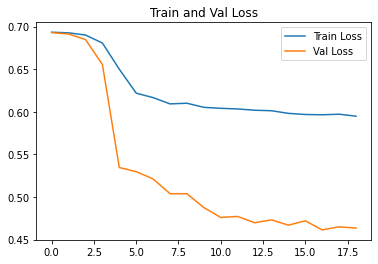

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9316    0.9410    0.9362     22447
           1     0.9407    0.9312    0.9359     22553

    accuracy                         0.9361     45000
   macro avg     0.9361    0.9361    0.9361     45000
weighted avg     0.9361    0.9361    0.9361     45000

混淆矩阵：
[[21122  1325]
 [ 1552 21001]]


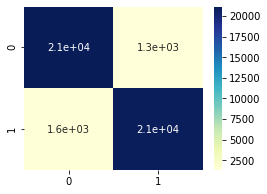

在训练集上的预测效果:


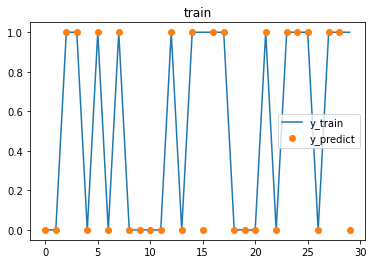

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8743    0.8715    0.8729      2553
           1     0.8664    0.8692    0.8678      2447

    accuracy                         0.8704      5000
   macro avg     0.8703    0.8704    0.8704      5000
weighted avg     0.8704    0.8704    0.8704      5000

混淆矩阵：
[[2225  328]
 [ 320 2127]]


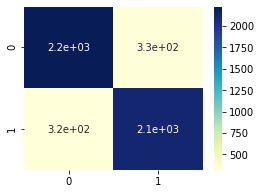

在测试集上的预测效果:


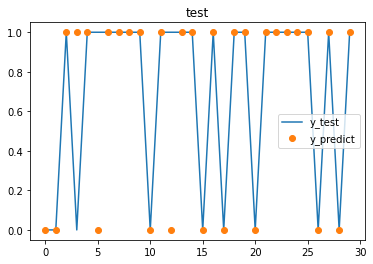

In [192]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

embedding_size = 2
rnn_units = 2
drop_rate = 0.9

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    bigru=GRU(units=rnn_units, return_sequences=False)(embeddings)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path)  
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### Bi-GRU

test number: 5000
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_148 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_94 (Embedding)     (None, 200, 1)            10000     
_________________________________________________________________
bidirectional_87 (Bidirectio (None, 4)                 48        
_________________________________________________________________
dropout_122 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 10        
Total params: 10,058
Trainable params: 10,058
Non-trainable params: 0
_________________________________________________________________
None
Train on 40500 samples, validate on 4500 samples
Epoch 1/50
40500/40500 [========================

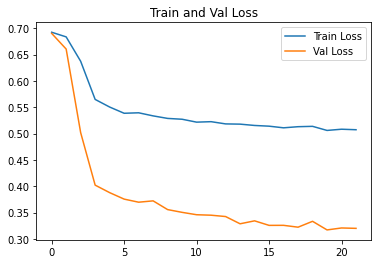

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9545    0.9474    0.9509     22447
           1     0.9481    0.9550    0.9515     22553

    accuracy                         0.9512     45000
   macro avg     0.9513    0.9512    0.9512     45000
weighted avg     0.9513    0.9512    0.9512     45000

混淆矩阵：
[[21267  1180]
 [ 1014 21539]]


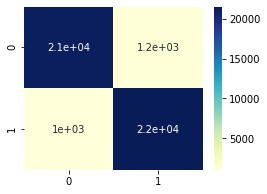

在训练集上的预测效果:


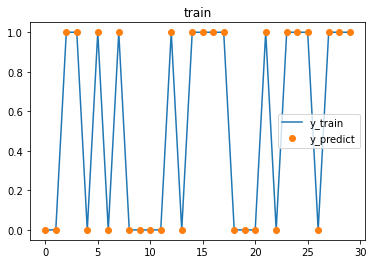

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8869    0.8566    0.8715      2553
           1     0.8556    0.8860    0.8705      2447

    accuracy                         0.8710      5000
   macro avg     0.8712    0.8713    0.8710      5000
weighted avg     0.8715    0.8710    0.8710      5000

混淆矩阵：
[[2187  366]
 [ 279 2168]]


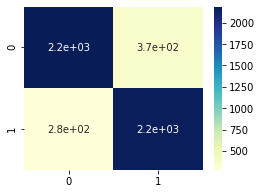

在测试集上的预测效果:


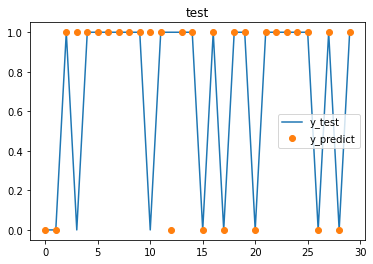

In [201]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

embedding_size = 1
rnn_units = 2
drop_rate = 0.9

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=False))(embeddings)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)

#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) 
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### CNN

test number: 5000
Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_141 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_88 (Embedding)     (None, 200, 2)            20000     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 2)            6         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 2)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 2)  

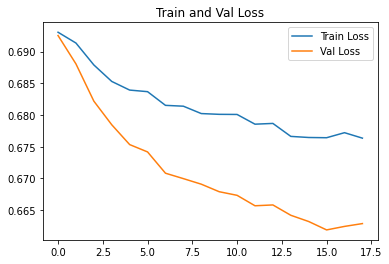

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.6720    0.7608    0.7137     22447
           1     0.7259    0.6305    0.6748     22553

    accuracy                         0.6955     45000
   macro avg     0.6990    0.6956    0.6943     45000
weighted avg     0.6990    0.6955    0.6942     45000

混淆矩阵：
[[17078  5369]
 [ 8334 14219]]


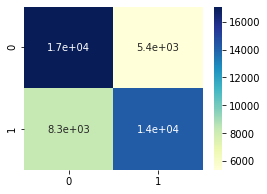

在训练集上的预测效果:


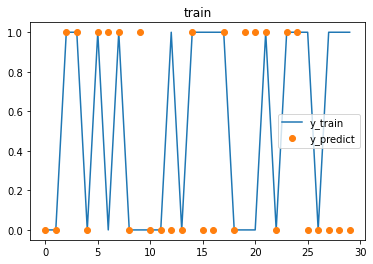

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.6734    0.7544    0.7116      2553
           1     0.7070    0.6183    0.6597      2447

    accuracy                         0.6878      5000
   macro avg     0.6902    0.6864    0.6857      5000
weighted avg     0.6899    0.6878    0.6862      5000

混淆矩阵：
[[1926  627]
 [ 934 1513]]


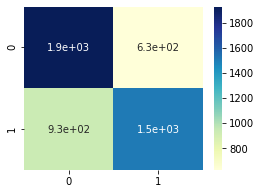

在测试集上的预测效果:


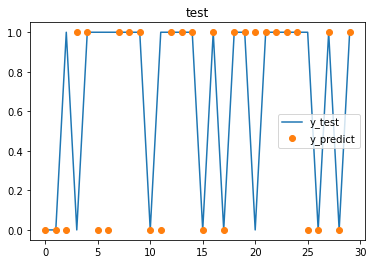

In [194]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))


def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=False, input_length=MAX_WORDS)(input_text)
    
    gc1 = Conv1D(filters=embedding_size, kernel_size=1, activation="tanh", use_bias=True)(embeddings)
    gc1m = MaxPooling1D(pool_size=200)(gc1)
    gc = Lambda(lambda x:K.squeeze(x, axis=1))(gc1m)
    dropout = Dropout(drop_rate)(gc)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path)  
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

### 3-5

#### Multi Bi-GRU

test number: 5000
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_95 (Embedding)     (None, 200, 1)            10000     
_________________________________________________________________
bidirectional_88 (Bidirectio (None, 200, 4)            48        
_________________________________________________________________
dropout_123 (Dropout)        (None, 200, 4)            0         
_________________________________________________________________
bidirectional_89 (Bidirectio (None, 4)                 84        
_________________________________________________________________
dropout_124 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_83 (Dense)             (None, 2)  

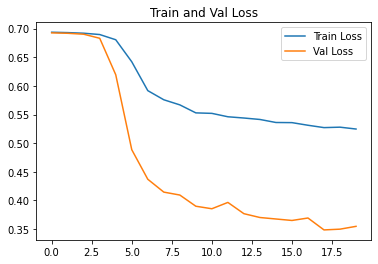

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9653    0.9003    0.9317     22447
           1     0.9070    0.9678    0.9364     22553

    accuracy                         0.9341     45000
   macro avg     0.9362    0.9341    0.9340     45000
weighted avg     0.9361    0.9341    0.9341     45000

混淆矩阵：
[[20209  2238]
 [  726 21827]]


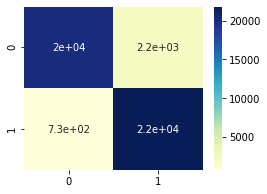

在训练集上的预测效果:


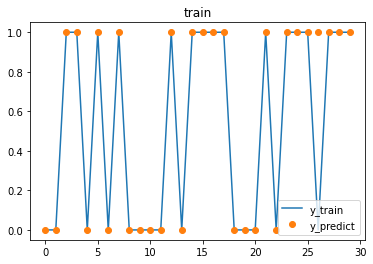

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9128    0.8198    0.8638      2553
           1     0.8301    0.9183    0.8719      2447

    accuracy                         0.8680      5000
   macro avg     0.8714    0.8690    0.8679      5000
weighted avg     0.8723    0.8680    0.8678      5000

混淆矩阵：
[[2093  460]
 [ 200 2247]]


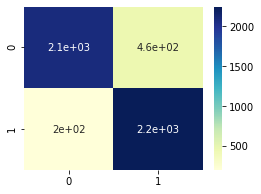

在测试集上的预测效果:


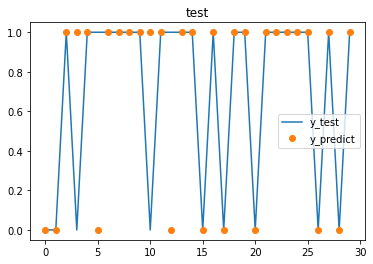

In [202]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

embedding_size = 1
rnn_units = 2
drop_rate = 0.9


def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(embeddings)
    dropout = Dropout(drop_rate)(bigru)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=False))(dropout)#bi-lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) #   
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### AB Multi Bi-GRU 1

In [203]:
from keras.models import Model
from keras.layers import Input
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import conv_utils
from keras import activations, initializers

embedding_size = 1
rnn_units = 2
drop_rate = 0.9

class myAttention1(Layer):
    """
    self defined topical attention layer.
    input: [hiddenStates, topicDistribution]
    input_shape: [(batch_size, seq_len, embedding_size), (batch_size, topic_num)]
    output: topical_text_feature
    output shape: (batch_size, embedding_size)
    """
    def __init__(self, **kwargs):
        super(myAttention1, self).__init__(**kwargs)
        # self.input_spec = InputSpec(min_ndim=3)
        self.supports_masking = True

    def build(self, input_shape):
        self.embedding_size = input_shape[-1]#hidden size
        self.seq_len = input_shape[1]

        # Create a trainable weight variable for this layer.
        self.v = self.add_weight(name='v',
                                 shape=(self.embedding_size, 1),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='u',
                                 shape=(self.embedding_size, self.embedding_size),
                                 initializer='random_normal',
                                 trainable=True)
        super(myAttention1, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x, mask=None):
        h = x
        h_ = K.reshape(h, [-1, self.embedding_size])
        h_u = K.dot(h_, self.u)
        h_u = K.reshape(h_u, [-1, self.seq_len, self.embedding_size])

        g = K.dot(K.tanh(h_u), self.v)
        weight = K.softmax(K.squeeze(g, axis=-1))
        weight = K.expand_dims(weight, axis=-1)
        weight = K.repeat_elements(weight, self.embedding_size, axis=-1)
        vec = weight * h
        vec = K.sum(vec, axis=1)
        return vec

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        output_shape = (input_shape[0], input_shape[-1])
        return output_shape

if __name__ == "__main__":
    input1 = Input(batch_shape=(256, 100, 300))
    topic_h = myAttention1()(input1)
    print(topic_h)    

Tensor("my_attention1_77/Sum:0", shape=(256, 300), dtype=float32)


test number: 5000
Model: "model_84"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_151 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_96 (Embedding)        (None, 200, 1)       10000       input_151[0][0]                  
__________________________________________________________________________________________________
bidirectional_90 (Bidirectional (None, 200, 4)       48          embedding_96[0][0]               
__________________________________________________________________________________________________
dropout_125 (Dropout)           (None, 200, 4)       0           bidirectional_90[0][0]           
_________________________________________________________________________

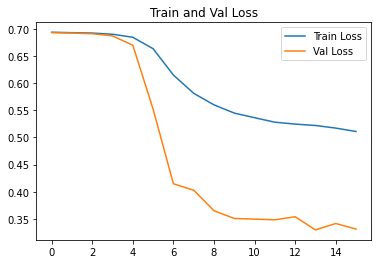

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9471    0.9261    0.9365     22447
           1     0.9281    0.9485    0.9382     22553

    accuracy                         0.9374     45000
   macro avg     0.9376    0.9373    0.9373     45000
weighted avg     0.9376    0.9374    0.9373     45000

混淆矩阵：
[[20789  1658]
 [ 1161 21392]]


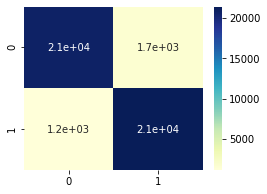

在训练集上的预测效果:


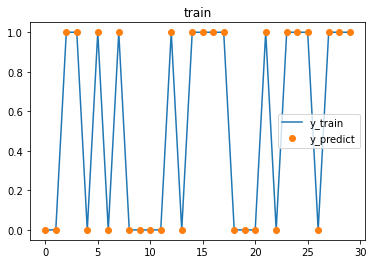

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8973    0.8621    0.8793      2553
           1     0.8618    0.8970    0.8791      2447

    accuracy                         0.8792      5000
   macro avg     0.8795    0.8796    0.8792      5000
weighted avg     0.8799    0.8792    0.8792      5000

混淆矩阵：
[[2201  352]
 [ 252 2195]]


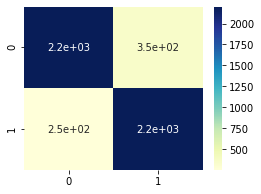

在测试集上的预测效果:


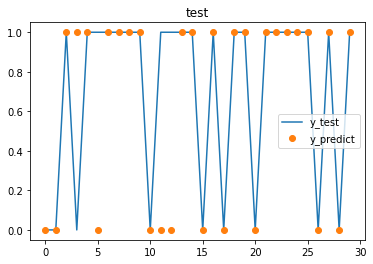

In [204]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

embedding_size = 1
rnn_units = 2
drop_rate = 0.9

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    att1 = myAttention1()
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    att1_out = att1(embeddings)
    
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(embeddings)
    dropout = Dropout(drop_rate)(bigru)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=False))(dropout)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    
    dropout = Concatenate(axis=1)([dropout, att1_out])
    
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path)  
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### AB Multi Bi-GRU 2

test number: 5000
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_152 (InputLayer)       (None, 200)               0         
_________________________________________________________________
embedding_97 (Embedding)     (None, 200, 1)            10000     
_________________________________________________________________
bidirectional_92 (Bidirectio (None, 200, 4)            48        
_________________________________________________________________
dropout_127 (Dropout)        (None, 200, 4)            0         
_________________________________________________________________
bidirectional_93 (Bidirectio (None, 200, 4)            84        
_________________________________________________________________
dropout_128 (Dropout)        (None, 200, 4)            0         
_________________________________________________________________
my_attention1_79 (myAttentio (None, 4)  

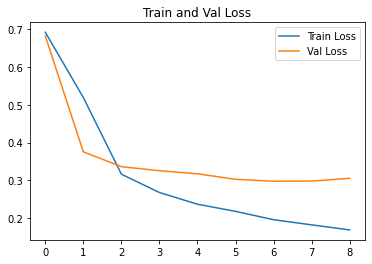

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9625    0.9409    0.9516     22447
           1     0.9424    0.9636    0.9529     22553

    accuracy                         0.9522     45000
   macro avg     0.9525    0.9522    0.9522     45000
weighted avg     0.9525    0.9522    0.9522     45000

混淆矩阵：
[[21120  1327]
 [  822 21731]]


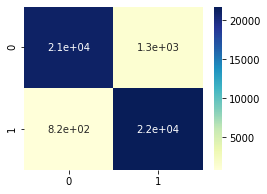

在训练集上的预测效果:


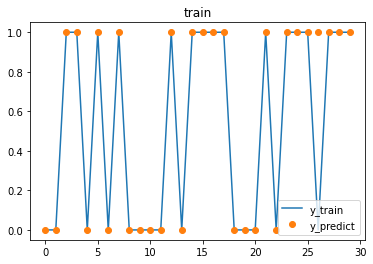

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8940    0.8590    0.8761      2553
           1     0.8587    0.8937    0.8759      2447

    accuracy                         0.8760      5000
   macro avg     0.8763    0.8764    0.8760      5000
weighted avg     0.8767    0.8760    0.8760      5000

混淆矩阵：
[[2193  360]
 [ 260 2187]]


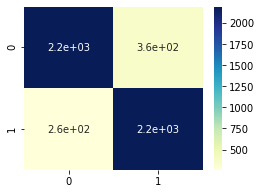

在测试集上的预测效果:


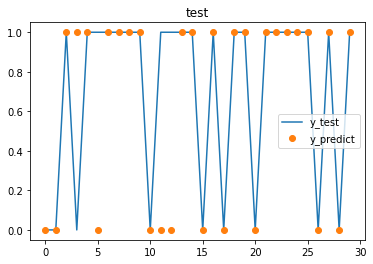

In [205]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))
embedding_size = 1
rnn_units = 2
drop_rate = 0.9

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    att2 = myAttention1()
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(embeddings)
    dropout = Dropout(drop_rate)(bigru)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(dropout)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    dropout = att2(dropout)
    
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path)  
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### AB Multi Bi-GRU 3

test number: 5000
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_98 (Embedding)        (None, 200, 1)       10000       input_153[0][0]                  
__________________________________________________________________________________________________
bidirectional_94 (Bidirectional (None, 200, 4)       48          embedding_98[0][0]               
__________________________________________________________________________________________________
dropout_129 (Dropout)           (None, 200, 4)       0           bidirectional_94[0][0]           
_________________________________________________________________________

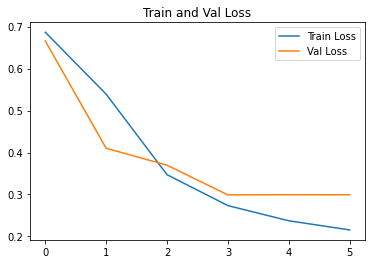

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9090    0.9608    0.9342     22447
           1     0.9587    0.9043    0.9307     22553

    accuracy                         0.9325     45000
   macro avg     0.9339    0.9326    0.9325     45000
weighted avg     0.9339    0.9325    0.9325     45000

混淆矩阵：
[[21568   879]
 [ 2158 20395]]


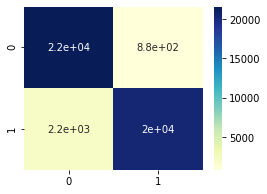

在训练集上的预测效果:


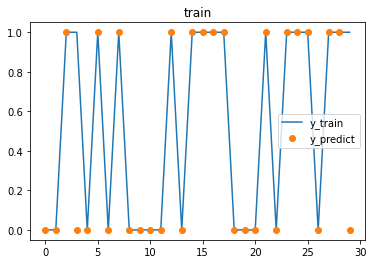

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8645    0.9095    0.8864      2553
           1     0.9002    0.8512    0.8750      2447

    accuracy                         0.8810      5000
   macro avg     0.8823    0.8804    0.8807      5000
weighted avg     0.8819    0.8810    0.8808      5000

混淆矩阵：
[[2322  231]
 [ 364 2083]]


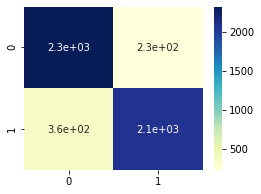

在测试集上的预测效果:


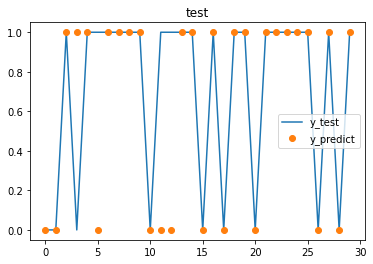

In [206]:
x_train,x_test, y_train, y_test = train_test_split(text_id,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))
embedding_size = 1
rnn_units = 2
drop_rate = 0.9

def modelDef():
 
    input_text = Input(shape=(MAX_WORDS, ))
    att1 = myAttention1()    
    att2 = myAttention1()
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    
    att1_out = att1(embeddings)
    
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(embeddings)
    dropout = Dropout(drop_rate)(bigru)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(dropout)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    dropout = att2(dropout)
    dropout = Concatenate(axis=1)([dropout, att1_out])
    
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= x_train,
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) #   
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict(x_train)
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict(x_test)
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

### 

#### data

In [46]:
def topic_one_hot(topic, topic_num):
    one_hots = np.zeros(topic_num, dtype=np.float32)
    for i in topic:
        one_hots[i[0]]=i[1]
    return one_hots

src_topic = [topic_one_hot(topici,topic_num) for topici in src_topic]
src_topic = np.array(src_topic)

In [82]:
x_all = np.hstack([text_id, src_topic])

In [165]:
x_train,x_test, y_train, y_test = train_test_split(x_all,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

test number: 5000


In [166]:
topic_train = x_train[:,-topic_num:]
topic_test = x_test[:,-topic_num:]
print(topic_train.shape)
print(topic_test.shape)

(45000, 24)
(5000, 24)


In [167]:
x_train = x_train[:,:-topic_num]
x_test = x_test[:,:-topic_num]
print(x_train.shape)
print(x_test.shape)

(45000, 200)
(5000, 200)


#### weight

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_120 (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
input_119 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
repeat_vector_39 (RepeatVector) (None, 200, 24)      0           input_120[0][0]                  
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 200, 20)      200000      input_119[0][0]                  
___________________________________________________________________________________________

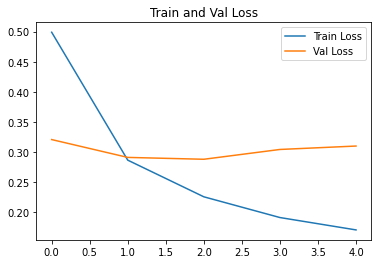

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9468    0.9545    0.9507     22447
           1     0.9544    0.9467    0.9505     22553

    accuracy                         0.9506     45000
   macro avg     0.9506    0.9506    0.9506     45000
weighted avg     0.9506    0.9506    0.9506     45000

混淆矩阵：
[[21426  1021]
 [ 1203 21350]]


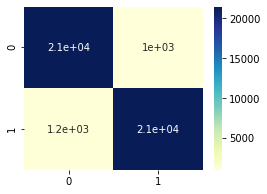

在训练集上的预测效果:


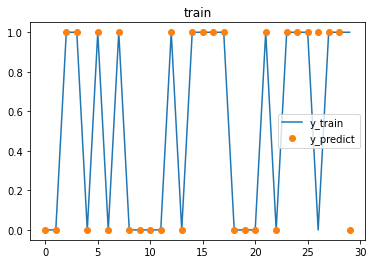

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8769    0.8790    0.8779      2553
           1     0.8734    0.8713    0.8723      2447

    accuracy                         0.8752      5000
   macro avg     0.8752    0.8751    0.8751      5000
weighted avg     0.8752    0.8752    0.8752      5000

混淆矩阵：
[[2244  309]
 [ 315 2132]]


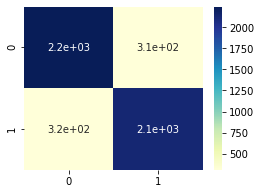

在测试集上的预测效果:


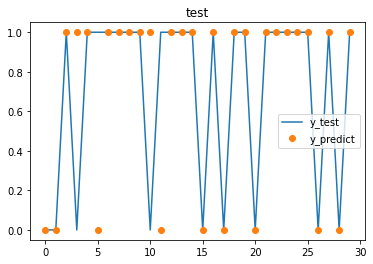

In [168]:
embedding_size = 20
rnn_units = 16
drop_rate = 0.1

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    input_topic = Input(shape=(topic_num,))
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    
    topic_embed = RepeatVector(MAX_WORDS)(input_topic)
    embeddings = Concatenate(axis=-1)([topic_embed, embeddings])
    
    bigru=GRU(units=rnn_units, return_sequences=False)(embeddings)#bi lstm
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text, input_topic], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= [x_train, topic_train],
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) # 
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]

predict_target=myModel.predict([x_train, topic_train])
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict([x_test, topic_test])
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

#### avg

In [169]:
x_train,x_test, y_train, y_test = train_test_split(x_all,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

topic_train = np.array([ np.mean(i) for i in x_train[:,-topic_num:]])
topic_test = np.array([ np.mean(i) for i in x_test[:,-topic_num:]])
print(topic_train.shape)
print(topic_test.shape)

x_train = x_train[:,:-topic_num]
x_test = x_test[:,:-topic_num]
print(x_train.shape)
print(x_test.shape)



test number: 5000
(45000,)
(5000,)
(45000, 200)
(5000, 200)


Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_122 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_121 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
repeat_vector_40 (RepeatVector) (None, 200, 1)       0           input_122[0][0]                  
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 200, 10)      100000      input_121[0][0]                  
___________________________________________________________________________________________

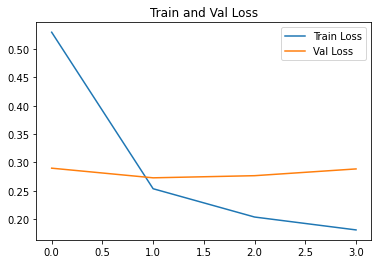

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9654    0.9105    0.9371     22447
           1     0.9157    0.9675    0.9409     22553

    accuracy                         0.9391     45000
   macro avg     0.9405    0.9390    0.9390     45000
weighted avg     0.9405    0.9391    0.9390     45000

混淆矩阵：
[[20438  2009]
 [  733 21820]]


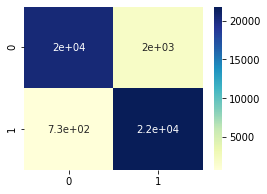

在训练集上的预测效果:


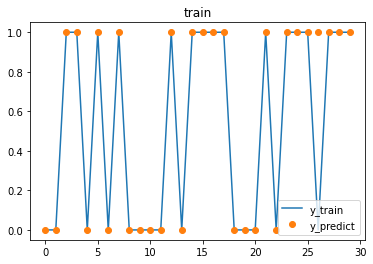

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9138    0.8261    0.8677      2553
           1     0.8351    0.9187    0.8749      2447

    accuracy                         0.8714      5000
   macro avg     0.8744    0.8724    0.8713      5000
weighted avg     0.8753    0.8714    0.8712      5000

混淆矩阵：
[[2109  444]
 [ 199 2248]]


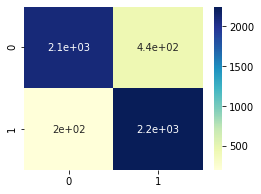

在测试集上的预测效果:


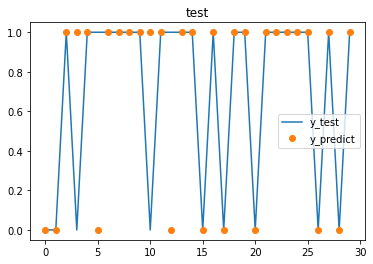

In [170]:
embedding_size = 10
rnn_units = 16
drop_rate = 0.1

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    input_topic = Input(shape=(1,))
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    
    topic_embed = RepeatVector(MAX_WORDS)(input_topic)
    embeddings = Concatenate(axis=-1)([topic_embed, embeddings])
    
    bigru=GRU(units=rnn_units, return_sequences=False)(embeddings)#双向LSTM层
    dropout = Dropout(drop_rate)(bigru)
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text, input_topic], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= [x_train, topic_train],
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path) #   
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict([x_train, topic_train])
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict([x_test, topic_test])
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

### abtegru

test number: 5000
(45000, 24)
(5000, 24)
(45000, 200)
(5000, 200)
Model: "model_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_158 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_159 (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_101 (Embedding)       (None, 200, 50)      500000      input_158[0][0]                  
__________________________________________________________________________________________________
repeat_vector_44 (RepeatVector) (None, 200, 24)      0           input_159[0][0]                  
_________________________

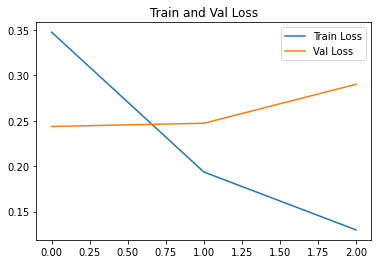

训练集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.9788    0.9768    0.9778     22447
           1     0.9769    0.9790    0.9780     22553

    accuracy                         0.9779     45000
   macro avg     0.9779    0.9779    0.9779     45000
weighted avg     0.9779    0.9779    0.9779     45000

混淆矩阵：
[[21926   521]
 [  474 22079]]


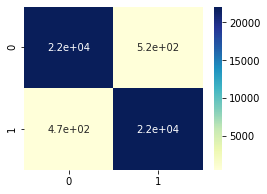

在训练集上的预测效果:


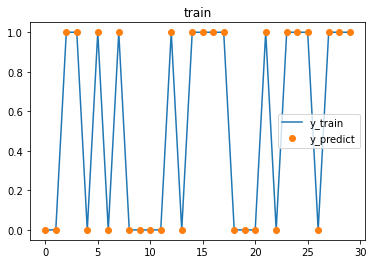

测试集:
精确度等指标：
              precision    recall  f1-score   support

           0     0.8994    0.8794    0.8893      2553
           1     0.8770    0.8974    0.8871      2447

    accuracy                         0.8882      5000
   macro avg     0.8882    0.8884    0.8882      5000
weighted avg     0.8885    0.8882    0.8882      5000

混淆矩阵：
[[2245  308]
 [ 251 2196]]


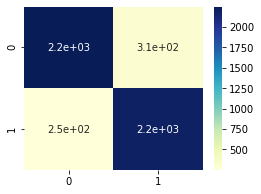

在测试集上的预测效果:


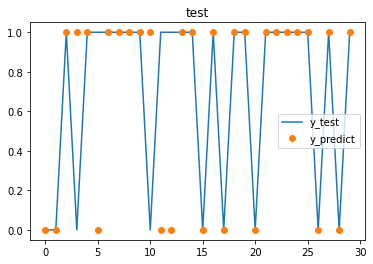

In [209]:
embedding_size = 50
rnn_units = 50
drop_rate = 0.1

x_train,x_test, y_train, y_test = train_test_split(x_all,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)
print('test number:',len(x_test))

topic_train = x_train[:,-topic_num:]
topic_test = x_test[:,-topic_num:]
print(topic_train.shape)
print(topic_test.shape)

x_train = x_train[:,:-topic_num]
x_test = x_test[:,:-topic_num]
print(x_train.shape)
print(x_test.shape)

from keras.layers import BatchNormalization

embedding_size = 50
rnn_units = 32
drop_rate = 0.1

def modelDef():
    input_text = Input(shape=(MAX_WORDS, ))
    input_topic = Input(shape=(topic_num,))
    
    att1 = myAttention1()    
    att2 = myAttention1()       
    
    embeddings = Embedding(input_dim=body_num + index_from,#vocab size
                           output_dim=embedding_size,
                           mask_zero=True, input_length=MAX_WORDS)(input_text)
    embeddings = BatchNormalization()(embeddings)
    att1_out = att1(embeddings)

    topic_embed = RepeatVector(MAX_WORDS)(input_topic)
    embeddings = Concatenate(axis=-1)([topic_embed, embeddings])
    
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(embeddings)#双向LSTM层
    dropout = Dropout(drop_rate)(bigru)
    bigru=Bidirectional(GRU(units=rnn_units, return_sequences=True))(dropout)#双向LSTM层
    dropout = Dropout(drop_rate)(bigru)

    dropout = att2(dropout)
    dropout = Concatenate(axis=1)([dropout, att1_out])
    
    Softmax = Dense(2, activation="softmax", use_bias=True)(dropout)
    model = Model(inputs=[input_text, input_topic], outputs=[Softmax])
    model.compile(optimizer="adam", loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

myModel = modelDef()
print(myModel.summary())
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath = model_name_path, monitor='val_loss', save_best_only=True)
history = myModel.fit(x= [x_train, topic_train],
                    y= [y_train],
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,callbacks=[es, cp],
                    validation_split=0.1)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

#myModel.load_weights(model_name_path)  
y_train = [inst.argsort()[-1] for inst in y_train]
y_test = [inst.argsort()[-1] for inst in y_test]
predict_target=myModel.predict([x_train, topic_train])
predict_target = [inst.argsort()[-1] for inst in predict_target]
predict_target2=myModel.predict([x_test, topic_test])
predict_target2 = [inst.argsort()[-1] for inst in predict_target2]
myResult()

